In [3]:
import numpy as np
# import astropy.units as u
from matplotlib import pyplot as plt
import time
from numba import njit,prange
# import scipy.interpolate as interpl
# from numba.extending import overload
# from mpl_toolkits.mplot3d import axes3d
# from matplotlib import cm
# from matplotlib import pyplot as plt

In [4]:
@njit(boundscheck=True)
def FDM_BIv03(Vrf, Vdc):
    
    #define the trap parameters
    #For the mirror ** For now, just assume there is no hole at the bottom or holes for the slits, and mirror takes up all of lower surface **
    Hmirror = .00323; #mirror height
    Ropening = .00508; # radius at Hmirror
    #for the top endcap ** For now, just assume its a retangular block over entire world **
    Htopcap = 0.0035; #distance from bottom of mirror to bottom of top end cap
    Ttopcap = .001; #thickness of top end cap
    PlateWidth = 0.013; #width of bias plate arms
    PlateLength = 0.01; # From center of mirror point to bias plate edge
    TGroundPlate = 0.001; #Thickness of grounded plate on top of Bias plates
    #for the needle ** For now, just assume it is a cylindrical block **
    Hneedle = -0.0004; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = 0.00023; #radius of needle
    HneedleTip = 0.0024; # height of needle tip from needle body
    RneedleTip = 0.00002;
    theta = 2*np.arctan(Rneedle/HneedleTip); #opening angle of needle tip cone

    #Not sure what to do with this yet: mirror_equation = (Hmirror / Ropening**2) * (x**2 +y**2); #the equation describing the shape of the mirror (paraboloid). form of z=(1/a^2)(x^2+y^2)
    
    #Properties of our grid
    gmax = 0.0075#what is this? (meters)
    points = 601
    steps = points - 1
    x = np.linspace(-gmax, gmax, points)
    y = np.linspace(-gmax, gmax, points)
    z = np.linspace(0, 2*gmax, points)
    size = len(x)
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2) #This could be  problem, since I want z to start from zero, not be centered at zero
    lattice_points=np.zeros((size**3,3))
    marker=0 #What do these mean?

    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 600 #number of iterations
    CenterV = np.zeros((iterations, 1)) #keep track of the potential value at the center at each iteration
    
    
    #Now define the boundry conditions

    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                
                #The top end cap Htopcap <= z <= Htopcap +Ttopcap
                #Arm one of Bias plates
                if ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] > Ropening -0.000) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[0]
                #Arm Two of bias plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] > Ropening-0.000) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[0]
                #Arm three of bias plate
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] < -Ropening +0.00) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[0]
                #Arm four of bias plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] < -Ropening+0.000) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[0]
                    
                #Grounded top plate
                 #Arm one of Grounded plates
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] > Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                #Arm Two of Grounded plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] > Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                #Arm three of grounded plate
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] < -Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                #Arm four of grounded plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] < -Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3] #what do these numbers mean?
                    V0dc[i, j, k] = Vdc[3]
                
                #The mirror
                elif ((z[k] > 0) and (z[k] < Hmirror) and (z[k] <= (Hmirror / Ropening**2) * (x[i]**2 + y[j]**2))):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                
                #The needle body
                elif ((y[j] < np.sqrt(Rneedle - x[i]**2)) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -np.sqrt(Rneedle - x[i]**2)) and (y[j] < Rneedle) and (y[j] > -Rneedle) and (z[k] > 0) and (z[k] < Hneedle)):
                #elif ((z[k] < ((x[i] + y[j]) + np.sqrt(3 * Rneedle**2 + 6 * x[i] * y[i])) / 2) and (z[k] > -((x[i] + y[j]) + np.sqrt(3 * Rneedle**2 + 6 * x[i] * y[i])) / 2) and (z[k] > 0) and (z[k] <Hneedle) and (np.abs(x[i]) < Rneedle) and (np.abs(y[j] < Rneedle))):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #The needle tip, subtracted Hneedle- from first thing, ugh, it doesn't work
                #elif ((z[k] < np.sqrt(x[i]**2 + y[j]**2) * np.tan(theta) / Rneedle) and (z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip) and (x[i]<Rneedle) and (x[i]> - Rneedle) and (y[j]<Rneedle) and (y[j]> - Rneedle)):
                elif ((z[k] < - np.sqrt(x[i]**2 + y[j]**2)*12.5 +0.002) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -Rneedle) and (y[j] < Rneedle) and (z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip)):
                #((x[i] > -np.sqrt(Rneedle**2 *(-z[k]+Hneedle)**2 / np.tan(theta) - y[j]**2) - Rneedle) and (y[j] < np.sqrt(Rneedle**2 *(-z[k]+Hneedle)**2 / np.tan(theta) - x[i]**2) + Rneedle) and (z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip)):
                    V0[i, j, k] = Vrf[2]#(z[k] < (np.sqrt(3)*np.sqrt(x[i]**2 + y[j]**2)+Hneedle))
                    V0dc[i, j, k] = Vdc[2]
                #the very tip of the needle (to hopefully avoid fringing effects)
                elif ((z[k] > 0.0019) and (z[k]< 0.0021) and (z[k] < np.sqrt(RneedleTip**2 - x[i]**2 - y[j]**2) + 0.002)):
                    V0[i, j, k] = Vrf[4]
                    V0dc[i, j, k] = Vdc[4]
                #elif ((z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip) and (x[i]<= ((HneedleTip - z[k])/ HneedleTip) *Rneedle * np.cos(theta)) and (y[j]<= ((HneedleTip - z[k])/ HneedleTip) *Rneedle * np.sin(theta))):
                #elif ((z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip) and (x[i] < (HneedleTip/Rneedle)*y[j] + Rneedle) and (x[i] > -(HneedleTip/Rneedle)*y[j] - Rneedle) and (y[j] < (HneedleTip/Rneedle)*x[i] + Rneedle) and (y[j] > -(HneedleTip/Rneedle)*x[i] - Rneedle)):
                #    V0[i, j, k] = Vrf[3]
                #    V0dc[i, j, k] = Vdc[3]
                    
               # and (x[i] < Rneedle) and (x[i] > -Rneedle)    and (z[k] > np.sqrt(x[i]**2 + y[j]**2))  
                #In the space with no electrodes:
                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
    lattice_points=lattice_points[0:marker] # what does this mean?
                
    V0_temp=V0    
    V0dc_temp=V0dc
    
    return V0,V0dc,CenterV,lattice_points,cords

In [5]:
    ###Sample voltages to use in the simulation
RF=np.array([0, 1, 1,1, 2])
DC=np.array([1, 1, 1, 1, 2])
####record the start time
start=time.time()
#Run the simulation
A=FDM_BIv03(RF,DC)
print("time elapsed = ",time.time()-start)

time elapsed =  86.59719514846802


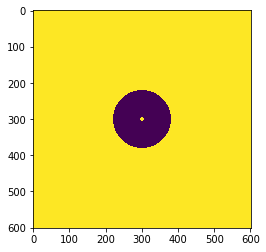

In [6]:
###################PLOTTING EXAMPLES###########
# plot the xy plane for the dc potential
plt.imshow(A[1][:,:,20], cmap=plt.cm.get_cmap('viridis', 20))
#plt.axis([70, 90, 290, 310]) #looking at z axis
#plt.axis([290, 310, 290, 310])
#plot the z axis for the RF potential
#plt.plot(plt.imshow(A[0][50,50,:]))

In [3]:
@njit(boundscheck=True)
def trap(Vrf, Vdc):
    
    #define the trap parameters
    eps = 0.97; #roughly the eccentricity
    f = 1; #flattening
    a = 0.05; #semi-minor axis
    c = 0.25*a; #distance from center to pole, semi major
    Rmin = 0.0125;
    m = 0.01; #additional mirror thickness horizontal
    t0 = -0.04; #The same as b, but negitive
    b0 = 0.0509; #minus sign in BC
    t = -0.025; #additional mirror thickness vertical for the top
    b = 0.04; #additional mirror thickness vertical for the bottom
    b2 = 0.025; #needs to be the same as t, but should always be positive, even if t is negitive
    t2 =  0.025;
    Hneedle = -0.001425; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = 0.00023; #radius of needle
    HneedleTip = 0.0024; # height of needle tip from needle body
    RneedleTip = 0.0001; # The ball on top of the needle
    Bneedle = b0; #where the needle begins

     
    
    #Properties of our grid
    gmax = 0.052 #physical size of the space simulated (meters)
    points = 401 # number of points that are being simulated
    steps = points - 1 # just the number of points minus one
    x = np.linspace(-gmax/2, gmax/2, points) #chosing how much space in the x, y, z direction, where it begins and where it ends
    y = np.linspace(-gmax/2, gmax/2, points)
    z = np.linspace(-gmax, 0, points)
    size = len(x) # telling it how to organize these spaces
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2) 
    lattice_points=np.zeros((size**3,3))
    marker=0 #What do these mean?
    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 600 #number of iterations
    CenterV = np.zeros((iterations,1)) #keep track of the potential value at the center at each iteration
    
    # Now define the boundry conditions
    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                
                #The ellipsoidal mirror part 1
                if ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > -b)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > -b)): #the bottom half of the ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > -b)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > -b)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > -b)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > -b)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                    
                #The ellipsoidal mirror part 2
                elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t2) and (z[k] > -b2)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t2) and (z[k] > -b2)): #the bottom half of the ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t2) and (z[k] > -b2)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t2) and (z[k] > -b2)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t2) and (z[k] > -b2)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t2) and (z[k] > -b2)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                    
                    #The ellipsoidal mirror part 3
                elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t0+0.02) and (z[k] > -b0+0.02)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t0) and (z[k] > -b0)): #the bottom half of the ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t0) and (z[k] > -b0)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t0) and (z[k] > -b0)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t0) and (z[k] > -b0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t0) and (z[k] > -b0)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                    
                #The needle
                elif ((y[j] < np.sqrt(Rneedle - x[i]**2)) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -np.sqrt(Rneedle - x[i]**2)) and (y[j] < Rneedle) and (y[j] > -Rneedle) and (z[k] > -Bneedle) and (z[k] < -Bneedle + Hneedle)):
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                #The needle tip
                elif ((z[k] < - np.sqrt(x[i]**2 + y[j]**2)*12.5) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -Rneedle) and (y[j] < Rneedle) and (z[k] > -Bneedle + Hneedle) and (z[k] < -Bneedle + Hneedle + HneedleTip)):
                    V0[i, j, k] = Vrf[4]
                    V0dc[i, j, k] = Vdc[4]
                #the very tip of the needle (to hopefully avoid fringing effects)
                elif ((z[k] > -Bneedle + Hneedle + HneedleTip - 0.0002) and (z[k] < -Bneedle + Hneedle + HneedleTip + 0.0002) and (z[k] < np.sqrt(RneedleTip**2 - x[i]**2 - y[j]**2))):
                    V0[i, j, k] = Vrf[5]
                    V0dc[i, j, k] = Vdc[5]
                


                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
                    
    lattice_points=lattice_points[0:marker] # what does this mean?    
    
    V0_temp=V0    
    V0dc_temp=V0dc
    
    return V0,V0dc,CenterV,lattice_points,cords

In [4]:
    ###Sample voltages to use in the simulation
RF=np.array([1,1,1,1, 1, 2])
DC=np.array([0, 0,0,0,0,0])
####record the start time
start=time.time()
#Run the simulation
A=trap(RF,DC)
print("time elapsed = ",time.time()-start)

time elapsed =  15.630902290344238


In [2]:
###################PLOTTING EXAMPLES###########
# plot the xy plane for the dc potential
plt.imshow(A[0][:,:,20])#, cmap=plt.cm.get_cmap('viridis', 2))
#plt.axis([70, 90, 290, 310]) #looking at z axis
plt.axis([0, 20, 190,210])
#plot the z axis for the RF potential
#plt.plot(plt.imshow(A[0][50,50,:]))

NameError: name 'plt' is not defined